In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
df = pd.read_csv('process_dataset.csv')
print(" Dataset Loaded Successfully")
print(df.head())

 Dataset Loaded Successfully
   cat__Type of Travel_Personal Travel  cat__Class_Eco  remainder__id  \
0                                  0.0             0.0        90035.0   
1                                  0.0             1.0        12360.0   
2                                  0.0             0.0        77959.0   
3                                  0.0             1.0        39177.0   
4                                  0.0             1.0        27508.0   

   remainder__Flight Distance  remainder__Inflight wifi service  \
0                      2863.0                               1.0   
1                       192.0                               2.0   
2                      3377.0                               0.0   
3                       311.0                               3.0   
4                       556.0                               5.0   

   remainder__Ease of Online booking  remainder__Online boarding  \
0                                3.0                         

In [13]:
X = df.drop(columns=['remainder__satisfaction_encoded'])
y = df['remainder__satisfaction_encoded']


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nTraining samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 15100
Testing samples: 3775


In [15]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
# Function to Create ANN Model
def create_ann_model(hidden_layers=1, neurons=32, learning_rate=0.001, dropout_rate=0.0):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))
    model.add(Dense(neurons, activation='relu'))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation='relu'))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [17]:
#Early Stopping Callback

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [18]:
# Train Default ANN

ann_default = create_ann_model()
history_default = ann_default.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)
y_pred_default = (ann_default.predict(X_test_scaled) > 0.5).astype(int)


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [19]:
# Train Manually Tuned ANN

ann_manual = create_ann_model(hidden_layers=2, neurons=64, learning_rate=0.0005, dropout_rate=0.2)
history_manual = ann_manual.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)
y_pred_manual = (ann_manual.predict(X_test_scaled) > 0.5).astype(int)

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [28]:
# Manual Grid Search (Simulated GridSearchCV)
param_grid = {
    'hidden_layers': [1, 2],
    'neurons': [32, 64],
    'learning_rate': [0.001, 0.0005]
}

best_acc = 0
best_params = {}
best_model = None

for hidden_layers in param_grid['hidden_layers']:
    for neurons in param_grid['neurons']:
        for lr in param_grid['learning_rate']:
            model = create_ann_model(hidden_layers=hidden_layers, neurons=neurons, learning_rate=lr)
            model.fit(
                X_train_scaled, y_train,
                validation_split=0.2,
                epochs=100,
                batch_size=32,
                callbacks=[early_stop],
                verbose=0
            )
            y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
            acc = accuracy_score(y_test, y_pred)
            if acc > best_acc:
                best_acc = acc
                best_params = {'hidden_layers': hidden_layers, 'neurons': neurons, 'learning_rate': lr}
                best_model = model

y_pred_best = (best_model.predict(X_test_scaled) > 0.5).astype(int)
print("\n✅ Best Grid Search Parameters:", best_params)
print("Best Accuracy:", best_acc)


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

✅ Best Grid Search Parameters: {'hidden_layers': 1, 'neurons': 64, 'learning_rate': 0.0005}
Best Accuracy: 0.9433112582781457


In [29]:
#  Evaluation Function
def evaluate_model(y_true, y_pred, model, X_test_scaled):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, model.predict(X_test_scaled).ravel())
    cm = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"AUC: {auc:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc, f1, prec, rec, auc


----- VARIETY 1: Default ANN -----
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9393
F1 Score: 0.9329
Precision: 0.9409
Recall: 0.9251
AUC: 0.9865

Confusion Matrix:
[[1953  100]
 [ 129 1593]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94      2053
         1.0       0.94      0.93      0.93      1722

    accuracy                           0.94      3775
   macro avg       0.94      0.94      0.94      3775
weighted avg       0.94      0.94      0.94      3775



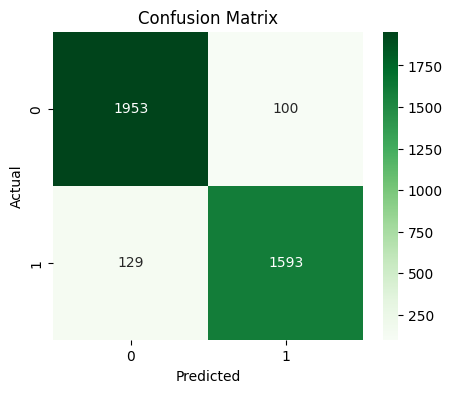


----- VARIETY 2: Manually Tuned ANN -----
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9399
F1 Score: 0.9328
Precision: 0.9517
Recall: 0.9146
AUC: 0.9886

Confusion Matrix:
[[1973   80]
 [ 147 1575]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95      2053
         1.0       0.95      0.91      0.93      1722

    accuracy                           0.94      3775
   macro avg       0.94      0.94      0.94      3775
weighted avg       0.94      0.94      0.94      3775



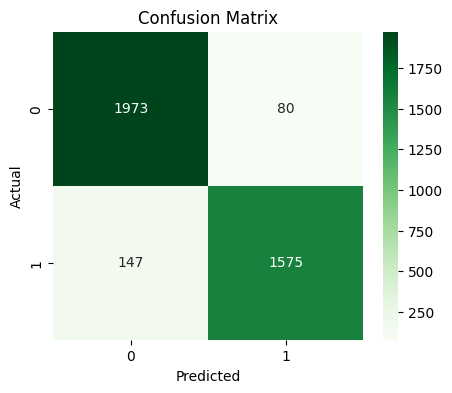


----- VARIETY 3: Grid Search Best ANN -----
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9433
F1 Score: 0.9373
Precision: 0.9462
Recall: 0.9286
AUC: 0.9872

Confusion Matrix:
[[1962   91]
 [ 123 1599]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      2053
         1.0       0.95      0.93      0.94      1722

    accuracy                           0.94      3775
   macro avg       0.94      0.94      0.94      3775
weighted avg       0.94      0.94      0.94      3775



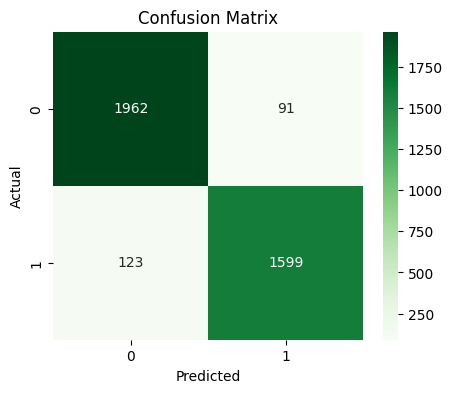

In [30]:
# Evaluate All Models

print("\n----- VARIETY 1: Default ANN -----")
metrics_default = evaluate_model(y_test, y_pred_default, ann_default, X_test_scaled)

print("\n----- VARIETY 2: Manually Tuned ANN -----")
metrics_manual = evaluate_model(y_test, y_pred_manual, ann_manual, X_test_scaled)

print("\n----- VARIETY 3: Grid Search Best ANN -----")
metrics_best = evaluate_model(y_test, y_pred_best, best_model, X_test_scaled)


In [33]:
#  Comparison Table
results = pd.DataFrame({
    'Model Variety': ['Default', 'Manual Tuned', 'Grid Search Best'],
    'Accuracy': [metrics_default[0], metrics_manual[0], metrics_best[0]],
    'F1 Score': [metrics_default[1], metrics_manual[1], metrics_best[1]],
    'Precision': [metrics_default[2], metrics_manual[2], metrics_best[2]],
    'Recall': [metrics_default[3], metrics_manual[3], metrics_best[3]],
    'AUC': [metrics_default[4], metrics_manual[4], metrics_best[4]],
})

print("\n==== Model Comparison Table ====")
print(results)


==== Model Comparison Table ====
      Model Variety  Accuracy  F1 Score  Precision    Recall       AUC
0           Default  0.939338  0.932943   0.940933  0.925087  0.986498
1      Manual Tuned  0.939868  0.932781   0.951662  0.914634  0.988594
2  Grid Search Best  0.943311  0.937280   0.946154  0.928571  0.987158


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


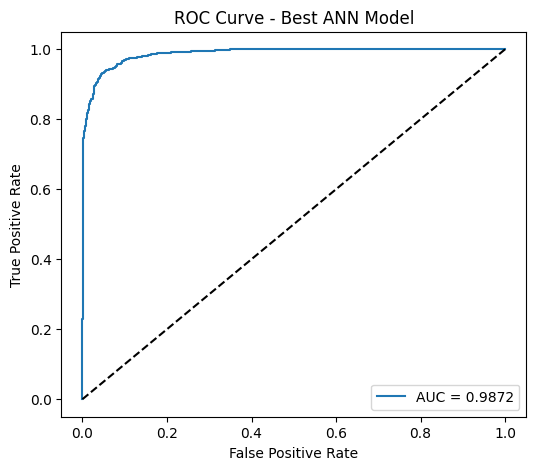

In [34]:
#  ROC Curve for Best Model
y_proba = best_model.predict(X_test_scaled).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Best ANN Model")
plt.legend()
plt.show()